In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

# WILD WITH FATHER

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'WILD_with_father'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [3]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [4]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells2500.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

In [6]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results/newvolumes/dict_results_across_mice_WILD_with_father2500.npy', dict_results_across_mice)

In [7]:
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_WILD_with_father2500.npy', 
                                   allow_pickle=True).item()

In [9]:
# remove unclean data
experimental_groups = utils.divide_in_exp_groups(list_subjects=list(dict_results_across_mice.keys()))
experimental_groups

{'Control': ['W10Control',
  'W38Control',
  'W26Control',
  'W15Control',
  'W31Control',
  'W23Control',
  'W7Control',
  'W29Control',
  'W3Control',
  'W17Control'],
 'Fam': ['W14Fam',
  'W16Fam',
  'W25Fam',
  'W5Fam',
  'W40Fam',
  'W36Fam',
  'W8Fam',
  'W34Fam'],
 'Unfam': ['W27Unfam',
  'W20Unfam',
  'W2Unfam',
  'W11Unfam',
  'W13Unfam',
  'W18Unfam']}

In [10]:
# dict_results_across_mice = np.load('dict_results/dict_results_across_mice_WILD_without_father2500.npy', 
#                                    allow_pickle=True).item()

In [11]:
subjects = list(dict_results_across_mice.keys())

In [12]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)


## Calculate number of cells

In [13]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [14]:
df_control_cell_count.set_index('area').sum()

W10Control    12128
W38Control    39907
W26Control    14219
W15Control    26607
W31Control    40416
W23Control    16849
W7Control     18122
W29Control    28858
W3Control     29800
W17Control    20326
dtype: int64

In [15]:
df_fam_cell_count.set_index('area').sum()

W14Fam    26340
W16Fam    28807
W25Fam    32747
W5Fam     15205
W40Fam    18653
W36Fam    36035
W8Fam      3959
W34Fam    20919
dtype: int64

In [16]:
df_unfam_cell_count.set_index('area').sum()

W27Unfam    30535
W20Unfam    17892
W2Unfam     35149
W11Unfam    29467
W13Unfam    39879
W18Unfam    29761
dtype: int64

In [17]:
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count],
                                        test='mannwhitneyu')
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.482227,0.312487,0.238109
1,Primary motor area,0.344639,0.393133,0.325689
2,Secondary motor area,0.25258,0.207969,0.474266
3,Primary somatosensory area,0.482282,0.178276,0.238838
4,Supplemental somatosensory area,0.25247,0.207969,0.423142
...,...,...,...,...
194,Interfascicular nucleus raphe,0.427173,0.285341,0.229674
195,Interpeduncular nucleus,0.464379,0.456622,0.422974
196,Rostral linear nucleus raphe,0.355436,0.473714,0.353407
197,Central linear nucleus raphe,0.182213,0.477354,0.255781


In [18]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [19]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,0.00145025
Ammon's horn,0.00566599
Septofimbrial nucleus,0.00810883
Triangular nucleus of septum,0.0138318
Suprageniculate nucleus,0.0288247
Ventral part of the lateral geniculate complex,0.0306239
Dentate gyrus,0.0342675
Paraventricular hypothalamic nucleus descending division,0.0404686
Paracentral nucleus,0.0492478


In [20]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Posterior amygdalar nucleus,0.000682196
Cortical amygdalar area,0.00142815
Medial amygdalar nucleus,0.00202444
Ventral premammillary nucleus,0.00280333
Claustrum,0.00393732
Piriform area,0.00733413
Postpiriform transition area,0.00985028
Piriform-amygdalar area,0.00985028
Intercalated amygdalar nucleus,0.012925


In [21]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Anterior olfactory nucleus,0.00846234
Ammon's horn,0.01658
Postpiriform transition area,0.0193264
Septofimbrial nucleus,0.0224573
Medial amygdalar nucleus,0.022694
Paraventricular hypothalamic nucleus descending division,0.0261436
Piriform area,0.0306073
Agranular insular area,0.0306073
Posterior amygdalar nucleus,0.0306073


## Calculate corr matrices on number of cells

In [22]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

Text(0.5, 1.0, 'CONTROL')

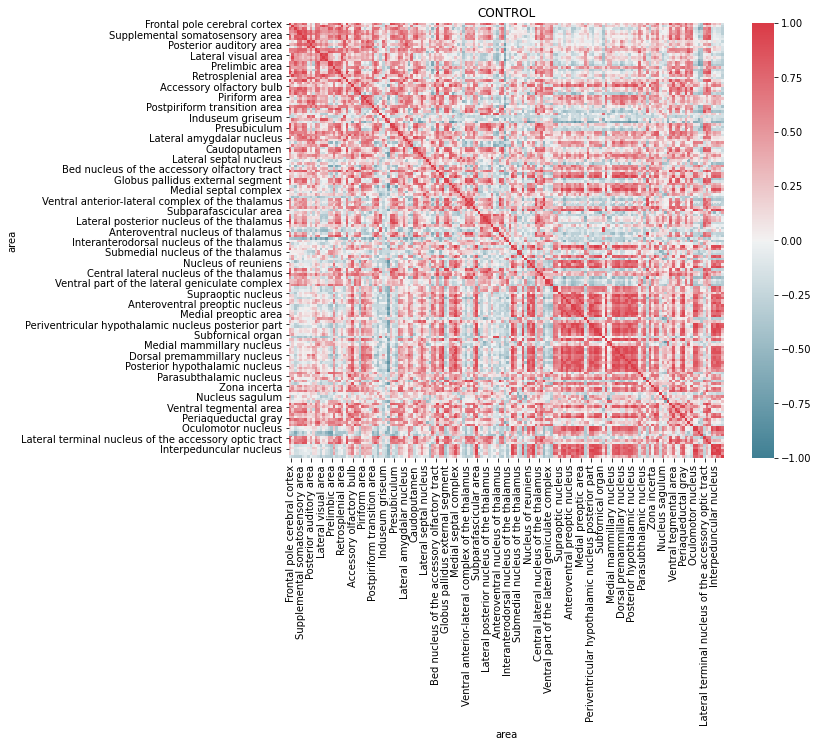

In [23]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

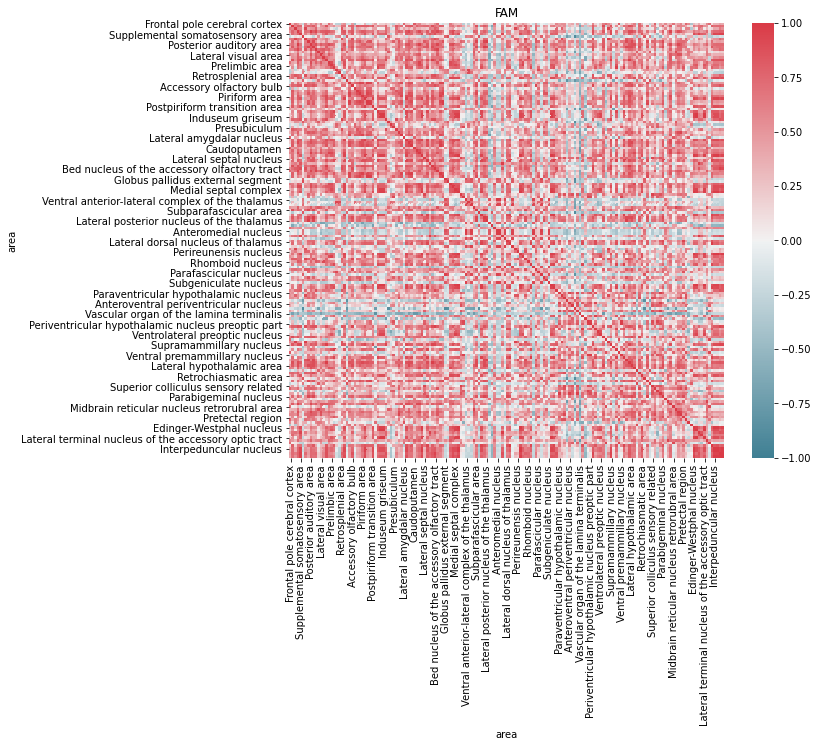

In [24]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

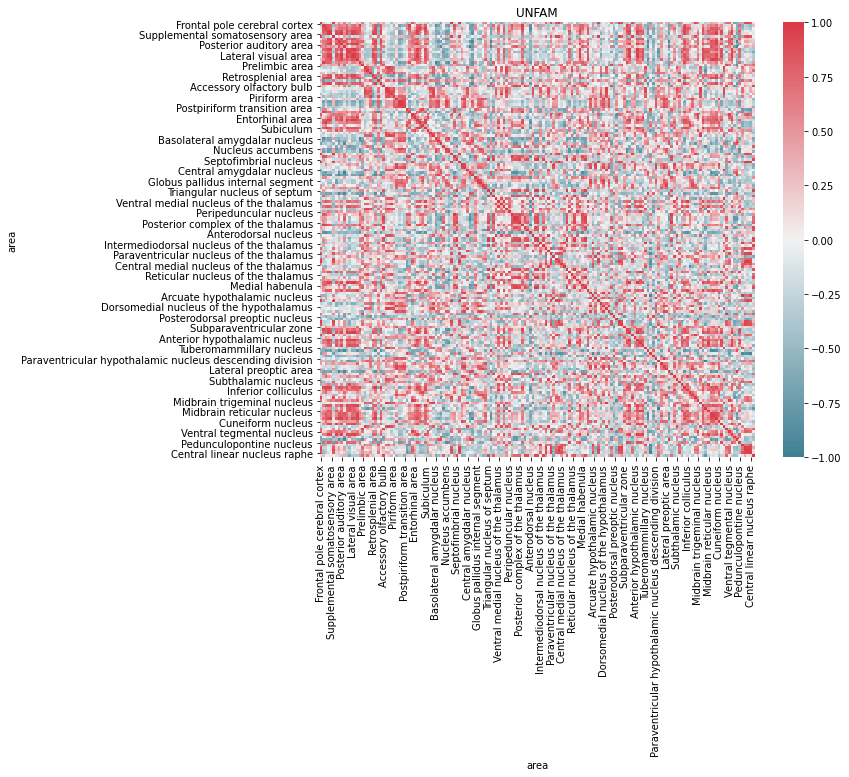

In [25]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

In [26]:
df_control_rd, df_fam_rd, df_unfam_rd = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='relative_density')
df_ttest_rd = ace.test_across_groups([df_control_rd,df_fam_rd,df_unfam_rd])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_rd = df_ttest_rd.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [27]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_rd.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,0.000109132
Septofimbrial nucleus,0.00187089
Cortical amygdalar area,0.0075572
Central amygdalar nucleus,0.0157257
Medial amygdalar nucleus,0.0205349
Paraventricular hypothalamic nucleus descending division,0.0299547
Accessory olfactory bulb,0.0431009
Nucleus sagulum,0.0450817
Triangular nucleus of septum,0.0466635


In [28]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_rd.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Posterior amygdalar nucleus,0.000687454
Claustrum,0.00270762
Cortical amygdalar area,0.00280396
Medial amygdalar nucleus,0.00649567
Piriform area,0.00703503
Postpiriform transition area,0.0221521
Piriform-amygdalar area,0.0331102
Ventral premammillary nucleus,0.050974
Anterior olfactory nucleus,0.0579301


## Histograms with father

<AxesSubplot:xlabel='area', ylabel='number of cells'>

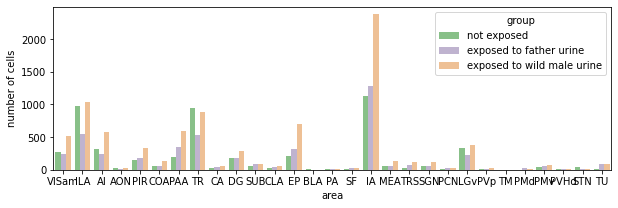

In [29]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['number of cells'] = [df_control_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['number of cells'] = [df_fam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to wild male urine' for area in areas_ttest]
unfam['number of cells'] = [df_unfam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax)

<AxesSubplot:xlabel='area', ylabel='energy'>

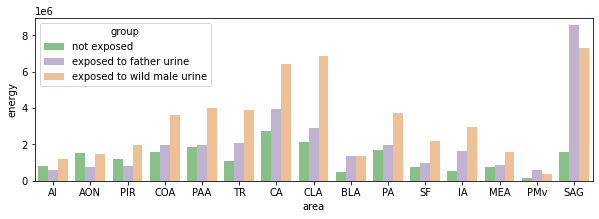

In [30]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')
df_ttest_energy = ace.test_across_groups([df_control_energy,df_fam_energy,df_unfam_energy])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['energy'] = [df_control_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['energy'] = [df_fam_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to wild male urine' for area in areas_ttest]
unfam['energy'] = [df_unfam_energy.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="energy", hue="group", palette="Accent", ax=ax)

# WILD without father

In [31]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'WILD_without_father'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [32]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [33]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results/newvolumes/dict_results_across_mice_WILD_without_father2500.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_WILD_without_father2500.npy', allow_pickle=True).item()

In [35]:
dict_results_across_mice.keys()

dict_keys(['W12Fam', 'W10Control', 'W6Unfam', 'W38Control', 'W26Control', 'W9Fam', 'W15Control', 'W31Control', 'W30Fam', 'W24Unfam', 'W23Control', 'W7Control', 'W35Unfam', 'W4Unfam', 'W32Fam', 'W1Fam', 'W29Control', 'W3Control', 'W28Unfam', 'W39Unfam', 'W22Fam', 'W17Control', 'W37Unfam'])

In [36]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)


In [37]:
experimental_groups

{'Control': ['W10Control',
  'W38Control',
  'W26Control',
  'W15Control',
  'W31Control',
  'W23Control',
  'W7Control',
  'W29Control',
  'W3Control',
  'W17Control'],
 'Fam': ['W12Fam', 'W9Fam', 'W30Fam', 'W32Fam', 'W1Fam', 'W22Fam'],
 'Unfam': ['W6Unfam',
  'W24Unfam',
  'W35Unfam',
  'W4Unfam',
  'W28Unfam',
  'W39Unfam',
  'W37Unfam']}

# Calculate number of cells

In [39]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [40]:
df_control_cell_count.set_index('area').sum()

W10Control    12128
W38Control    33014
W26Control    14219
W15Control    26607
W31Control    40416
W23Control    16849
W7Control     18122
W29Control    28858
W3Control     29800
W17Control    20326
dtype: int64

In [41]:
df_fam_cell_count.set_index('area').sum()

W12Fam    24813
W9Fam     28103
W30Fam    39350
W32Fam    29027
W1Fam     40106
W22Fam    45559
dtype: int64

In [42]:
df_unfam_cell_count.set_index('area').sum()

W6Unfam     17974
W24Unfam    32843
W35Unfam    81500
W4Unfam     31262
W28Unfam    27061
W39Unfam    35159
W37Unfam    34223
dtype: int64

In [43]:
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count],
                                        test='mannwhitneyu')

In [44]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [45]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Primary motor area,0.00283862
Tuberal nucleus,0.00537366
Posterior amygdalar nucleus,0.00537366
Basolateral amygdalar nucleus,0.00733413
Piriform-amygdalar area,0.00985028
Main olfactory bulb,0.00985028
Medial amygdalar nucleus,0.00985028
Cortical amygdalar area,0.0130898
Piriform area,0.0172119


In [46]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Postpiriform transition area,0.000380153
Agranular insular area,0.00199529
Piriform-amygdalar area,0.00270696
Main olfactory bulb,0.00485294
Primary motor area,0.00641335
Secondary motor area,0.0084023
Cortical amygdalar area,0.0109135
Piriform area,0.0109135
Ventral part of the lateral geniculate complex,0.0174355


In [47]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Ventral part of the lateral geniculate complex,0.00896848
Dorsomedial nucleus of the hypothalamus,0.0134046
Anterior tegmental nucleus,0.0244432
Parastrial nucleus,0.0250922
Subgeniculate nucleus,0.0266745
Ventral tegmental area,0.026892
Posterior limiting nucleus of the thalamus,0.0299751
Posterior amygdalar nucleus,0.0314641
Ventral tegmental nucleus,0.0354852


# Calculate corr matrices on number of cells

In [48]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

Text(0.5, 1.0, 'CONTROL')

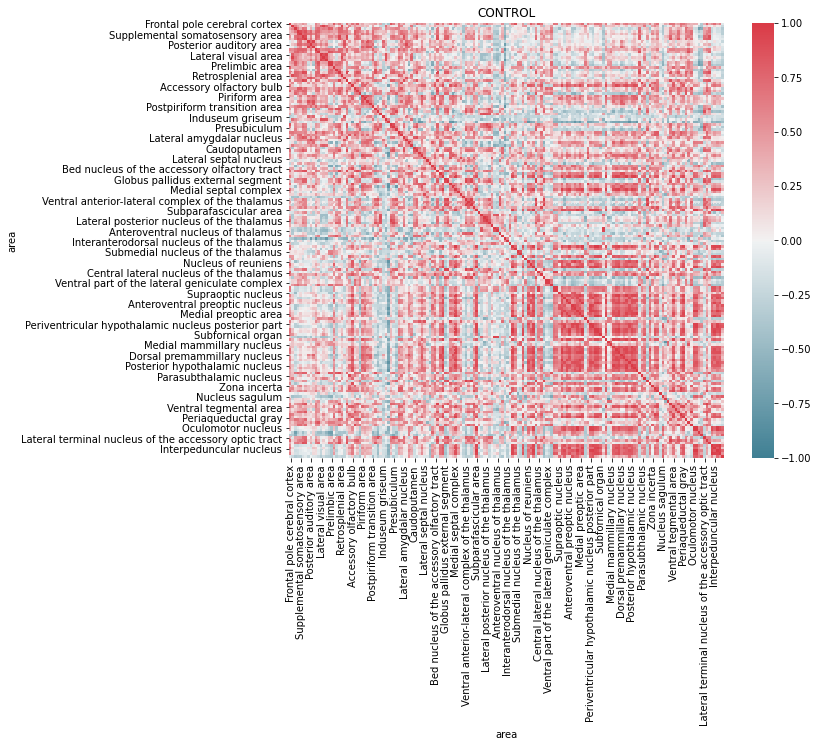

In [49]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

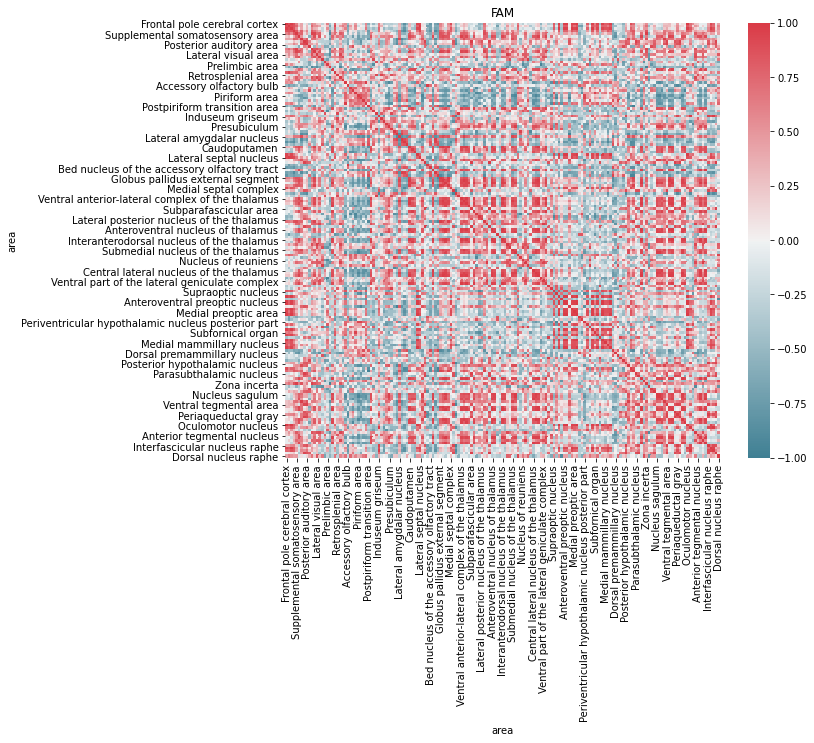

In [50]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

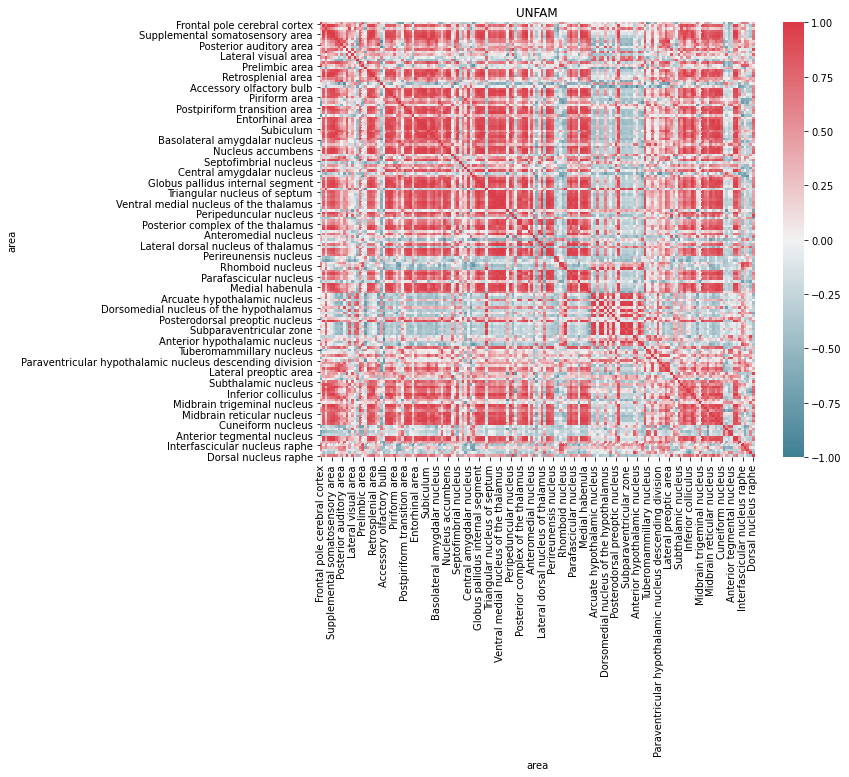

In [51]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

## Histograms WITHOUT FATHER

<AxesSubplot:xlabel='area', ylabel='number of cells'>

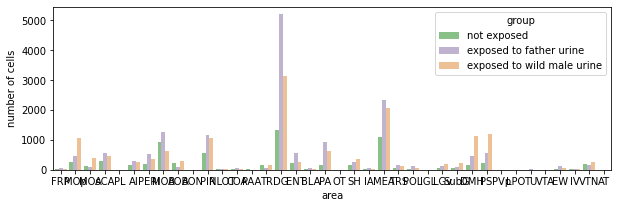

In [52]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['number of cells'] = [df_control_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['number of cells'] = [df_fam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to wild male urine' for area in areas_ttest]
unfam['number of cells'] = [df_unfam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax)

<AxesSubplot:xlabel='area', ylabel='energy'>

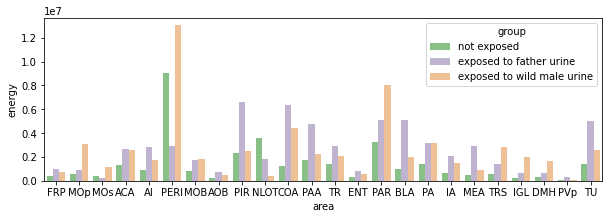

In [53]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')
df_ttest_energy = ace.test_across_groups([df_control_energy,df_fam_energy,df_unfam_energy])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['energy'] = [df_control_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['energy'] = [df_fam_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to wild male urine' for area in areas_ttest]
unfam['energy'] = [df_unfam_energy.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="energy", hue="group", palette="Accent", ax=ax)